# Journal 2022-12-26
Playing around with a few things over the Christmas holidays.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import (create_engine, MetaData, Table, Column, select, func, case, and_, or_, bindparam, literal)
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import sympy as sp

# Matrix Multiplication in SQL
Representing matrix multiplication as SQL statements.  Generalize to more operations?

In [3]:
engine = create_engine('sqlite:///:memory')

In [4]:
metadata = MetaData()

In [5]:
a = np.random.randn(3, 2)
b = np.random.randn(2, 5)

In [6]:
a @ b

array([[ 0.5620373 ,  0.72110803, -0.77081704,  0.17534859, -1.00891196],
       [ 2.23274874,  2.03398181, -2.55964766,  2.42443556, -3.49059107],
       [-3.17409347, -3.41992757,  3.95845544, -2.34751396,  5.29137769]])

In [7]:
def to_df(a):
    """Convert matrix to pandas DataFrame

    :param a: numpy matrix
    :return: pandas DataFrame with columns row, col, value i.e. sparse COO format
    """
    sp_a = coo_matrix(a)
    df_a = pd.DataFrame({'row': sp_a.row, 'col': sp_a.col, 'value': sp_a.data})
    return df_a

In [8]:
df_a = to_df(a)
df_b = to_df(b)

In [9]:
# Matrix multiplication: step 1 create intermediate matrix (with repeated elements at same row, col index) by scalar multiplication of elements
df_m = pd.merge(df_a, df_b, left_on=df_a.col, right_on=df_b.row).assign(value=lambda x: x['value_x'] * x['value_y'])

In [10]:
len(df_a), a.shape, len(df_b), b.shape, len(df_m)

(6, (3, 2), 10, (2, 5), 30)

In [11]:
# Step 2 sum reduction of elements with same row, col index
df_m.groupby(['row_x', 'col_y'])['value'].sum().unstack()

col_y,0,1,2,3,4
row_x,,,,,
0,0.562037,0.721108,-0.770817,0.175349,-1.008912
1,2.232749,2.033982,-2.559648,2.424436,-3.490591
2,-3.174093,-3.419928,3.958455,-2.347514,5.291378


In [12]:
# Check
a @ b

array([[ 0.5620373 ,  0.72110803, -0.77081704,  0.17534859, -1.00891196],
       [ 2.23274874,  2.03398181, -2.55964766,  2.42443556, -3.49059107],
       [-3.17409347, -3.41992757,  3.95845544, -2.34751396,  5.29137769]])

In [13]:
# Same result using pivot table
df_m.pivot_table(index='row_x', columns='col_y', values='value', aggfunc='sum')

col_y,0,1,2,3,4
row_x,,,,,
0,0.562037,0.721108,-0.770817,0.175349,-1.008912
1,2.232749,2.033982,-2.559648,2.424436,-3.490591
2,-3.174093,-3.419928,3.958455,-2.347514,5.291378


Note that we can generalize matrix multiplication by:

* replacing scalar operation `*` in creation of `df_m` by another operation (does it have to be commutative?)
* replacing the `sum` aggregation with another aggregation e.g. mean (median?)

## SQL Version

In [14]:
_ = df_a.to_sql('a', engine, if_exists='replace')
_ = df_b.to_sql('b', engine, if_exists='replace')

In [15]:
tb_a = Table('a', metadata, autoload_with=engine)
tb_b = Table('b', metadata, autoload_with=engine)

In [16]:
tb_m = select(
    [
        tb_a.c.row,
        tb_b.c.col,
        func.sum(tb_a.c.value * tb_b.c.value).label('value')
    ]
).select_from(
    tb_a.join(tb_b, tb_a.c.col == tb_b.c.row)
).group_by(
    tb_a.c.row, tb_b.c.col
).cte('mat_mul')

In [17]:
pd.read_sql(select(tb_m), engine).set_index(['row', 'col']).unstack()

value                                        
col         0         1         2         3         4
row                                                  
0    0.562037  0.721108 -0.770817  0.175349 -1.008912
1    2.232749  2.033982 -2.559648  2.424436 -3.490591
2   -3.174093 -3.419928  3.958455 -2.347514  5.291378

# Tensorflow Probability

In [18]:
x = tfd.Normal(loc=0., scale=1.)

In [19]:
x.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.281754  ,  2.256232  ,  0.9428515 ,  0.17475103, -0.43933585,
       -0.69611067, -0.8339144 ,  1.5406293 ,  0.03201488,  1.4160179 ],
      dtype=float32)>

In [20]:
mu = sp.symbols('mu', real=True)
mu

mu

In [21]:
# Fails: can't convert sympy object to tensor
# x_s = tfd.Normal(loc=mu, scale=1.)

In [22]:
# Fails: can't convert sympy object to tensor
# x.prob(mu)

In [23]:
from sympy.stats import Normal, density, variance, P, E

In [24]:
x_s = Normal('x', mu, 1)
x_s

x

In [25]:
E(x_s)

mu

In [26]:
P(x_s >= 1).simplify()

erf(sqrt(2)*(mu - 1)/2)/2 + 1/2

In [27]:
density(x_s)

NormalDistribution(mu, 1)

In [28]:
# Probability of a point is zero for continuous distribution
P(x_s == 2)

0

In [29]:
# Instead evaluate the probability density function
sp.log(density(x_s)(2)).simplify()

-(mu - 2)**2/2 - log(pi)/2 - log(2)/2

## MaxLike
Fit $\mu$ by maximising the likelihood of the data.  Introduce indexed variables for x an y

In [30]:
i, n = sp.symbols('i n', integer=True)
x_i = sp.Indexed('x', i)
x_i

x[i]

In [31]:
y_i = sp.Indexed('y', i)

In [32]:
sp.product(density(x_s)(y_i - mu*x_i), (i, 0, n))

(sqrt(2)/(2*sqrt(pi)))**(n + 1)*Product(exp(-(-mu*x[i] - mu + y[i])**2/2), (i, 0, n))

In [33]:
sp.log(sp.product(density(x_s)(y_i - mu*x_i), (i, 0, n))).simplify()

log((sqrt(2)/(2*sqrt(pi)))**(n + 1)*Product(exp(-(-mu*x[i] - mu + y[i])**2/2), (i, 0, n)))

In [34]:
# Need to manually change from product to log sum (probably a way to get sympy to do this for me)
sp.summation(sp.expand_log(sp.log(density(x_s)(y_i - mu*x_i).simplify())), (i, 0, n)).simplify()

(-mu**2/2 - log(pi)/2 - log(2)/2)*Sum(1, (i, 0, n)) + Sum(log(exp(mu*y[i])*exp(-mu**2*x[i])*exp(-mu**2*x[i]**2/2)*exp(mu*x[i]*y[i])*exp(-y[i]**2/2)), (i, 0, n))

In [35]:
# In principle solving for mu that has gradient w.r.t. mu equal to zero should work but doesn't seem to for general n upper limit.  To investigate.
sp.solve(sp.summation(sp.log(density(x_s)(y_i - mu*x_i)), (i, 0, n)).simplify().diff(mu), mu)[0].simplify()

Sum((-mu*x[i] - 2*mu + y[i])*x[i] + y[i], (i, 0, n))/(n + 1)

# Flexible Probability Distributions
Chapter 6 of Probabilistic Deep Learning - discretized logistic mixture

In [36]:
locs = (4.0, 10.0)
scales = (0.25, 0.5)
probs = (0.8, 0.2)

dists = tfd.Logistic(loc=locs, scale=scales)

From [Chapter 6 notebook](https://github.com/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_01.ipynb) with change from deprecated
`tfb.AffineScalar(shift, scale)` to `tfb.Shift(shift)(tfb.Scale(scale))`

In [39]:
def quantize(inner, low=0, bits=4):
    trans = tfd.TransformedDistribution(distribution=inner,bijector=tfb.Shift(-0.5))
    return tfd.QuantizedDistribution(trans,low=low,high=2**bits - 1.)

In [40]:
quant = quantize(dists, bits=4)

In [46]:
quant_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=probs),
    components_distribution=quant
)
mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=probs),
    components_distribution=dists
)

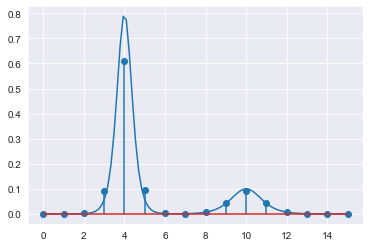

In [51]:
x = np.linspace(0., 15., 100)
n_vals = np.linspace(0,15,16) #0,1,2,3,...,15 discrete values
p = mixture.prob(x).numpy()
_ = plt.plot(x, p)
p = quant_mixture.prob(n_vals).numpy()
_ = plt.stem(n_vals, p)

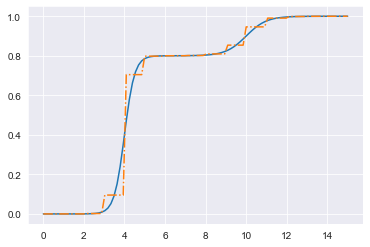

In [58]:
P = mixture.cdf(x).numpy()
_ = plt.plot(x, P)
P = quant_mixture.cdf(x).numpy()
_ = plt.plot(x, P, ls='-.')